In [11]:
from netCDF4 import Dataset
from calendar import monthrange
from cartoplot import cartoplot
import mask
from field_importer import get_field
from regrid import regrid
import os
import xarray as xr
import subprocess


/home/robbie/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [28]:
directory = '/home/robbie/Dropbox/SM_Thickness/data/cds_type'
destination = '/home/robbie/Dropbox/SM_Thickness/data/cds_type/monmeans'

# First iterate through the years where OSISAF data is available

for subdir in os.listdir(directory):
    
    # Print the year
    
    print(subdir)
    
    # One directory doesn't correspond to a year, but instead to monthly means. Ignore thyis
    
    if subdir != 'raw' and subdir != 'monmeans':
        
        # For a given year, iterate through the months inside
        
        for monthdir in os.listdir(directory + '/' + subdir):
            
#             Print the month name

            if True == True:

                print(monthdir)

    #             Choose the month name

                os.chdir(directory + '/' + subdir + '/' + monthdir)

                # This puts all the netcdfs into one, daily file

                p = subprocess.Popen(['cdo', 'mergetime', '*.nc', 'timeseries.nc' ])

                p.wait()

                # This averages that single daily file into a new monthly mean file

                p = subprocess.Popen(['cdo', 'monmean', 'timeseries.nc', f'{subdir}_{monthdir}_monthlymean.nc'])

                p.wait()

                # This moves that monthly mean file into a new destination folder where all the means can be analysed

#                 p = subprocess.Popen(['cp', subdir+'/'monthdir+'monthlymean.nc', destination])

#                 p.wait()

raw
2002
10
03
11
04
12
2003
02
01
10
03
11
04
12
2005
02
01
10
03
11
04
12
2004
02
01
10
03
11
04
12


In [12]:
yearlist = [2002,2003,2004,2005]

monthlist_2002 = ["03","04","10","11","12"]
monthlist_full = ["01","02","03","04","10","11","12"]

W99_OSISAF = {"depth":{},"density":{},"SWE":{}}

lon_target, lat_target = mask.get('lon'),mask.get('lat')

for year in yearlist:
    
    if year == 2002:
        monthlist = monthlist_2002
    else:
        monthlist = monthlist_full
    
    for month in monthlist:
        
        data = get_field('cds',month,year,variable='type',resolution=432)
        
        data_361 = regrid(data['field'],data['lon'],data['lat'],lon_target,lat_target)
        
        output = {'field':data_361,'lon':lon_target,'lat':lat_target}
        
        att_dict = {'title': 'Monthly sea ice type data regridded on 361x361 EASE grid',
                    'month': f'{month}',
                    'year':f'{year}'}
        
        ds = xr.Dataset( data_vars={'ice_type':(['x','y'],output['field'])},
                             coords={'lon':(['x','y'],output['lon']),
                                     'lat':(['x','y'],output['lat'])},
                             attrs=att_dict)
        
        ds.to_netcdf(f'/home/robbie/Dropbox/SM_Thickness/data/CDS_type/monmeans/361/{year}_{month}_monthlymean.nc','w')

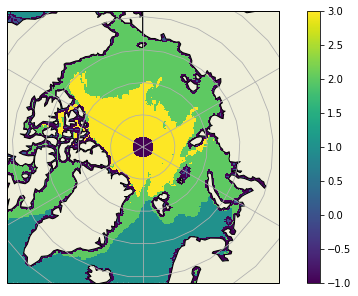

In [15]:
data = get_field('cds',"01",2004,variable='type',resolution=361)

cartoplot(data['lon'],data['lat'],data['field'])

In [2]:
from netCDF4 import Dataset
data = Dataset('/home/robbie/Dropbox/SM_Thickness/data/CDS_type/monmeans/2003_11_monthlymean.nc')
print(data)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    history: Tue Mar 17 19:17:06 2020: cdo monmean timeseries.nc 2003_11_monthlymean.nc
Tue Mar 17 19:17:06 2020: cdo mergetime *.nc timeseries.nc
20180615T213526Z (created)
    source: FCDR of SMMR / SSMI / SSMIS Brightness Temperatures R3 (doi: 10.5676/EUM_SAF_CM/FCDR_MWI/V003),ERA-Interim fields from ECMWF (doi: 10.1002/qj.828),EUMETSAT OSI SAF Sea Ice Concentration v2p0 (doi: 10.15770/EUM_SAF_OSI_0008)
    institution: Norwegian Meteorological Institute
    Conventions: CF-1.6 ACDD-1.3
    title: Sea Ice Type
    summary: Daily gridded Level-3 Sea Ice Type Climate Data Record (CDR) from passive microwave satellite data (SMMR, SSM/I, and SSMIS) for the period January 1979 - December 2015. The processing chain features: 1) correction of atmospheric noise using a Radiative Transfer Model, 2) dynamic tuning of algorithms fro

In [6]:

year = 2002
file = f'iceage_nh_12.5km_{year}0101_{year}1231_v4.1.nc'

data = Dataset(data_dir+file)

In [7]:
monthlist = list(range(1,13))

days_in_month = {}

for monthnum in monthlist:
    days = monthrange(year, monthnum)[1]
    days_in_month[monthnum] = days
    
print(days_in_month)

{1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}


In [9]:
remainder = 0

for month in days_in_month.keys():
    
    days_in = days_in_month[month] - (7-remainder)
    
    remainder = days_in%7
    
    month ave = first four months plus remainder. 

1 31 3
2 28 0
3 31 3
4 30 2
5 31 3
6 30 2
7 31 3
8 31 3
9 30 2
10 31 3
11 30 2
12 31 3
